In [1]:
''' 
This notebook is an example for the application of a Hopfield Network.

The first four positive integers are given as initial learning patterns, each described by a 100 neurons.
A corrupted pattern, similar to one of the learning patterns, will be defined and recognized by the system after some iterations.
The recognition process is based on a previously defined interaction matrix 'W'.
The asynchronous algorithm updates only one random neuron each step while the synchronous one updates all neurons simultaneously.

This file accesses a C extension file via the library 'cytpes'.
'''
import matplotlib.pyplot as plt
import numpy as np
from ctypes import *

patternNumber = 4 # Number of learning patterns
patternSize = 10 # Number of neurons per column/ row
iterations = 10 # Number of iterations

# Defining the learning patterns
patterns = np.array([
   [1,1,1,1,-1,-1,1,1,1,1,1,1,1,1,-1,-1,1,1,1,1,1,1,1,1,-1,-1,1,1,1,1,1,1,1,1,-1,-1,1,1,1,1,1,1,1,1,-1,-1,1,1,1,1,1,1,1,1,-1,-1,1,1,1,1,1,1,1,1,-1,-1,1,1,1,1,1,1,1,1,-1,-1,1,1,1,1,1,1,1,1,-1,-1,1,1,1,1,1,1,1,1,-1,-1,1,1,1,1],   # Number One
   [-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,1,1,1,1,1,1,1,-1,-1,1,1,1,1,1,1,1,1,-1,-1,1,1,1,1,1,1,1,1,-1,-1,1,1,1,1,1,1,1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,1,1,1,1,1,1,1,-1,-1,1,1,1,1,1,1,1,1,-1,-1,1,1,1,1,1,1,1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1],   # Number Two
   [-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,1,1,1,1,1,1,1,-1,-1,1,1,1,1,1,1,1,1,-1,-1,1,1,1,1,1,1,1,1,-1,-1,1,1,-1,-1,-1,-1,-1,-1,-1,-1,1,1,-1,-1,-1,-1,-1,-1,-1,-1,1,1,1,1,1,1,1,1,-1,-1,1,1,1,1,1,1,1,1,-1,-1,1,1,1,1,1,1,1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1],     # Number Three
   [-1,-1,1,1,1,-1,-1,1,1,1,-1,-1,1,1,1,-1,-1,1,1,1,-1,-1,1,1,1,-1,-1,1,1,1,-1,-1,1,1,1,-1,-1,1,1,1,-1,-1,1,1,1,-1,-1,1,1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,1,1,1,1,-1,-1,1,1,1,1,1,1,1,1,-1,-1,1,1,1,1,1,1,1,1,-1,-1,1,1,1,1,1,1,1,1,-1,-1,1,1,1],], # Letter M 
   dtype=np.float64)

# Show patterns
fig, ax = plt.subplots(1, patternNumber, figsize=(15, 10))

for i in range(patternNumber):
    ax[i].matshow(patterns[i].reshape((patternSize, patternSize)), cmap='gray')
    ax[i].set_xticks([])
    ax[i].set_yticks([])


In [2]:
# Load C extension for obtaining the interaction matrix and training the network.
cExt = CDLL('kernel.dll')

In [3]:
# Get the interaction matrix from the C extension.
def setInteractionMatrix(pN, pS, pS2, Pmat, Wmat):
    
    cExt_setInteractionMatrix = cExt.setInteractionMatrix
    
    cExt_setInteractionMatrix.argtypes = [
        c_int, 
        c_int, 
        c_int, 
        np.ctypeslib.ndpointer(dtype=np.float64, ndim=2, shape=(pN, pS2)), 
        np.ctypeslib.ndpointer(dtype=np.float64, ndim=2, shape=(pS2, pS2))
    ]
    cExt_setInteractionMatrix.restype = None
    
    cExt_setInteractionMatrix(pN, pS, pS2, Pmat, Wmat)

W = np.zeros((patternSize**2,patternSize**2), dtype=np.float64)

setInteractionMatrix(patternNumber, patternSize, patternSize**2, patterns, W)

In [4]:
# Print the interaction matrix 'W'
W

array([[0. , 0.4, 0.2, ..., 0.2, 0.2, 0.2],
       [0.4, 0. , 0.2, ..., 0.2, 0.2, 0.2],
       [0.2, 0.2, 0. , ..., 0.4, 0.4, 0.4],
       ...,
       [0.2, 0.2, 0.4, ..., 0. , 0.4, 0.4],
       [0.2, 0.2, 0.4, ..., 0.4, 0. , 0.4],
       [0.2, 0.2, 0.4, ..., 0.4, 0.4, 0. ]])

[]

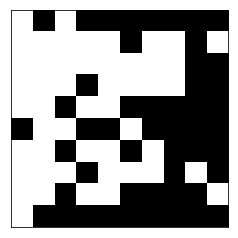

In [5]:
# Create a corrupted pattern.
testPattern = np.array([1,1,1,1,-1,-1,1,1,1,1,-1,1,1,1,1,-1,1,1,1,1,1,1,1,1,-1,-1,1,1,1,-1,1,1,1,1,-1,1,1,1,1,1,1,1,1,1,-1,1,1,-1,1,1,1,-1,1,1,-1,-1,1,1,1,-1,1,1,1,1,-1,-1,1,1,-1,1,1,1,1,-1,-1,-1,1,1,1,1,-1,1,1,-1,-1,-1,1,1,1,1,1,1,1,1,-1,-1,1,1,1,1],     
   dtype=float)

# Create another corrupted pattern. To try out the pattern above, rename this one, e.g., to 'testPattern2'.
testPattern = np.array([1,-1,1,-1,-1,-1,-1,-1,-1,-1,1,1,1,1,1,-1,1,1,-1,1,1,1,1,1,1,1,1,1,-1,-1,1,1,1,-1,1,1,1,1,-1,-1,1,1,-1,1,1,-1,-1,-1,-1,-1,-1,1,1,-1,-1,1,-1,-1,-1,-1,1,1,-1,1,1,-1,1,-1,-1,-1,1,1,1,-1,1,1,1,-1,1,-1,1,1,-1,1,1,-1,-1,-1,-1,1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1],
   dtype=float)
   
# Show the first corrupted pattern.
fig, ax = plt.subplots()
ax.matshow(testPattern.reshape((patternSize, patternSize)), cmap='gray')
ax.set_xticks([])
ax.set_yticks([])

In [6]:
# Get the distance matrix from the C extension.
def setDistanceMatrix(itN, pN, pS, pS2, Pmat, Wmat, nVec, Dmat):
    
    cExt_setDistanceMatrix = cExt.setDistanceMatrix
    
    cExt_setDistanceMatrix.argtypes = [
        c_int, 
        c_int, 
        c_int,
        c_int,
        np.ctypeslib.ndpointer(dtype=np.float64, ndim=2, shape=(pN, pS2)), 
        np.ctypeslib.ndpointer(dtype=np.float64, ndim=2, shape=(pS2, pS2)),
        np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, shape=(pS2)),
        np.ctypeslib.ndpointer(dtype=np.float64, ndim=2, shape=(itN, pN))
    ]
    cExt_setDistanceMatrix.restype = None
    
    cExt_setDistanceMatrix(itN, pN, pS, pS2, Pmat, Wmat, nVec, Dmat)

array([[54., 20.,  8., 52.],
       [53., 19.,  7., 51.],
       [53., 19.,  1., 53.],
       [53., 19.,  1., 53.],
       [53., 19.,  1., 53.],
       [53., 19.,  1., 53.],
       [52., 20.,  0., 54.],
       [52., 20.,  0., 54.],
       [52., 20.,  0., 54.],
       [52., 20.,  0., 54.]])

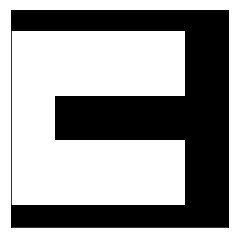

In [7]:
# Applying the algorithm.
newVector = testPattern
distanceMatrix = np.zeros((iterations, patternNumber))

setDistanceMatrix(iterations, patternNumber, patternSize, patternSize**2, patterns, W, newVector, distanceMatrix)

# Plotting the distance matrix as well as the solution proposed by the algorithm.
fig, ax = plt.subplots()
ax.matshow(newVector.reshape((patternSize, patternSize)), cmap='gray')
ax.set_xticks([])
ax.set_yticks([])
distanceMatrix

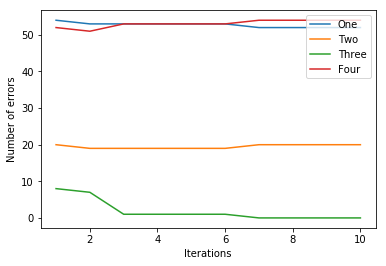

In [8]:
# Number of errors for each pattern against the number of performed iterations by the algorithm.
plt.plot(np.tensordot(np.arange(1,11),np.ones(4),axes=0), distanceMatrix)
plt.xlabel('Iterations')
plt.ylabel('Number of errors')
plt.legend(["One","Two","Three","Four"], loc=1)
plt.show()